In [1]:
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomTranslation, RandomRotation, RandomContrast, RandomBrightness, Lambda, UpSampling2D, Input, Rescaling, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

c:\Users\12ped\anaconda3\envs\tf_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GPU Config

In [2]:
import tensorflow as tf
tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:0a:00.0, compute capability: 8.6



---

## Dataset

In [3]:
# Download dataset from kaggle
imgs_path = r'./dataset'

In [4]:
# Data augmentation
datagen = ImageDataGenerator(
    # rescale=1/255.,
    rotation_range=22.5,
    zoom_range=(0.7, 1),
    horizontal_flip=True,
    validation_split=0.15,
    brightness_range=(0.5, 1.5),
)

train_generator = datagen.flow_from_directory(
    imgs_path,
    target_size=(224, 224), 
    batch_size=8,
    shuffle=True,
    subset='training',
    class_mode='categorical'
)  

validation_generator = datagen.flow_from_directory(
    imgs_path,
    target_size=(224, 224),
    batch_size=1,
    shuffle=True,
    subset='validation',
    class_mode='categorical'
)

class_labels = list(train_generator.class_indices.keys())
print('Class labels: ', class_labels)

Found 474 images belonging to 6 classes.


Found 83 images belonging to 6 classes.
Class labels:  ['cachorro', 'coelho', 'gato', 'hamster', 'passaro', 'peixe']


In [5]:
# unique, inverse = np.unique(train_generator.labels, return_inverse=True)
# onehot = np.eye(unique.shape[0])[inverse]

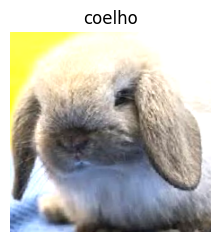

In [6]:
plt.figure(figsize=(15,15))
for X_batch, y_batch in validation_generator:
    for i in range(min(20, len(X_batch))):
        plt.subplot(4, 5, i + 1)  
        plt.imshow(X_batch[i]/255)
        plt.title(class_labels[np.where(y_batch[i] == 1)[0][0]])  
        plt.axis('off')  
    plt.show()  
    break  

---

## Model

1. Building the model

In [7]:
backbone = ResNet50(
    weights='imagenet',
    include_top=False,
)

In [8]:
backbone.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [9]:
# Freeze backbone
backbone.trainable = False

# Preprocessing pipeline
data_augmentation = Sequential([
    RandomFlip(mode='horizontal_and_vertical'),
    RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='constant', interpolation='bilinear', fill_value=0.0,),
    RandomRotation(factor=0.125, fill_mode='constant', fill_value=0.0, interpolation='bilinear'),
    RandomContrast(factor=0.4),
    RandomBrightness(factor=0.4),
])

preprocessing = Sequential([
    # UpSampling2D(size=(7,7)),
    Lambda(preprocess_input), # ResNet50 preprocessing
])

# Build the network (backbone + classification head)
model = Sequential([
    Input(shape=(224,224,3)),
    # data_augmentation,
    preprocessing,
    backbone,
    GlobalAveragePooling2D(),
    Flatten(),
    # Dense(1024, activation='relu'),
    # Dense(512, activation='relu'),
    Dense(6, activation = 'softmax'),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        CategoricalAccuracy(name='Accuracy'),
        Precision(name='Precision'),
        Recall(name='Recall'),
    ]
)

# Print the summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_____________________________________

2. Transfer Learning

In [ ]:
# Transfer Learning
history = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data=validation_generator,
    shuffle=True,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            mode='min',
            patience=10,
            restore_best_weights=True,
        )
    ]
)

Epoch 1/100


C:\Users\12ped\AppData\Local\Temp\ipykernel_40068\4130036454.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


60/60 [==============================] - 10s 103ms/step - loss: 0.7823 - Accuracy: 0.7257 - Precision: 0.8434 - Recall: 0.6477 - val_loss: 0.2566 - val_Accuracy: 0.9157 - val_Precision: 0.9500 - val_Recall: 0.9157
Epoch 2/100
60/60 [==============================] - 5s 81ms/step - loss: 0.1546 - Accuracy: 0.9599 - Precision: 0.9718 - Recall: 0.9451 - val_loss: 0.1693 - val_Accuracy: 0.9398 - val_Precision: 0.9750 - val_Recall: 0.9398
Epoch 3/100
60/60 [==============================] - 5s 80ms/step - loss: 0.1039 - Accuracy: 0.9747 - Precision: 0.9786 - Recall: 0.9662 - val_loss: 0.1367 - val_Accuracy: 0.9518 - val_Precision: 0.9512 - val_Recall: 0.9398
Epoch 4/100
60/60 [==============================] - 5s 80ms/step - loss: 0.0607 - Accuracy: 0.9916 - Precision: 0.9936 - Recall: 0.9873 - val_loss: 0.1826 - val_Accuracy: 0.9398 - val_Precision: 0.9512 - val_Recall: 0.9398
Epoch 5/100
60/60 [==============================] - 5s 80ms/step - loss: 0.0574 - Accuracy: 0.9852 - Precision: 0

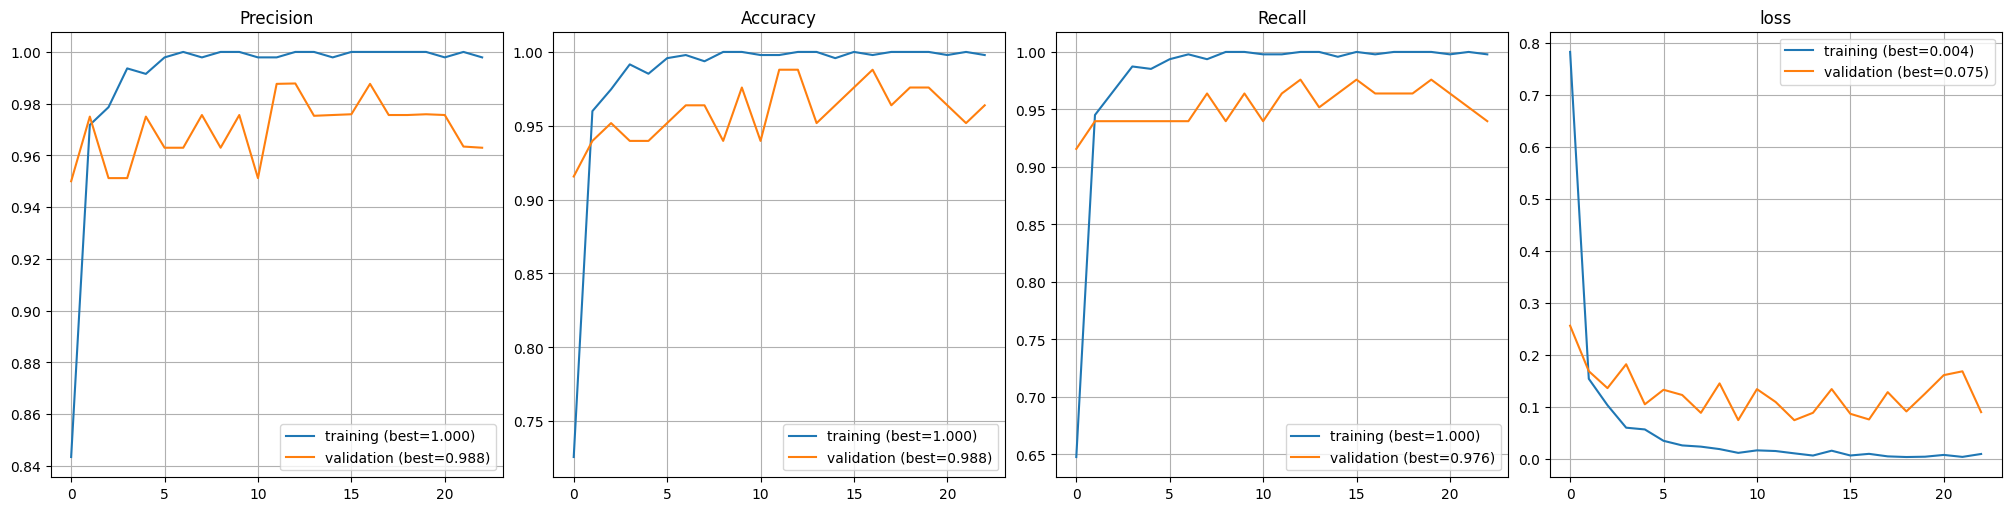

In [11]:
h_df = pd.DataFrame(history.history)

metrics = set([k.split('_')[-1] for k in history.history.keys()])

fig, axs = plt.subplots(ncols=len(metrics), nrows=1, constrained_layout=True, figsize=(20,5))

for plot_idx, metric in enumerate(metrics):
    best = h_df.max(0) if metric != 'loss' else h_df.min(0)
    axs[plot_idx].plot(
        history.history[metric],
        label=f'training (best={best[metric]:.3f})'
    )
    axs[plot_idx].plot(
        history.history['val_'+metric],
        label=f'validation (best={best["val_"+metric]:.3f})'
    )
    axs[plot_idx].grid(True)
    axs[plot_idx].set_title(metric)
    axs[plot_idx].legend()

3. Fine Tunning

In [18]:
# Unfreeze the backbone
backbone.trainable = True

# Fine-Tunning
history = model.fit(
    train_generator,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    shuffle=True,
    callbacks=[
        EarlyStopping(
            monitor="val_Accuracy",
            mode='max',
            patience=3,
            restore_best_weights=True,
        )
    ]
)

Epoch 1/10
60/60 [==============================] - 6s 88ms/step - loss: 0.0071 - Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - val_loss: 0.1317 - val_Accuracy: 0.9639 - val_Precision: 0.9639 - val_Recall: 0.9639
Epoch 2/10
60/60 [==============================] - 5s 87ms/step - loss: 0.0084 - Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - val_loss: 0.1400 - val_Accuracy: 0.9639 - val_Precision: 0.9639 - val_Recall: 0.9639
Epoch 3/10
60/60 [==============================] - 5s 86ms/step - loss: 0.0128 - Accuracy: 0.9979 - Precision: 0.9979 - Recall: 0.9979 - val_loss: 0.1166 - val_Accuracy: 0.9639 - val_Precision: 0.9753 - val_Recall: 0.9518
Epoch 4/10
60/60 [==============================] - 5s 85ms/step - loss: 0.0087 - Accuracy: 1.0000 - Precision: 1.0000 - Recall: 1.0000 - val_loss: 0.0491 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_Recall: 0.9880
Epoch 5/10
60/60 [==============================] - 5s 87ms/step - loss: 0.0189 - Accuracy: 0.9958 - Precisi

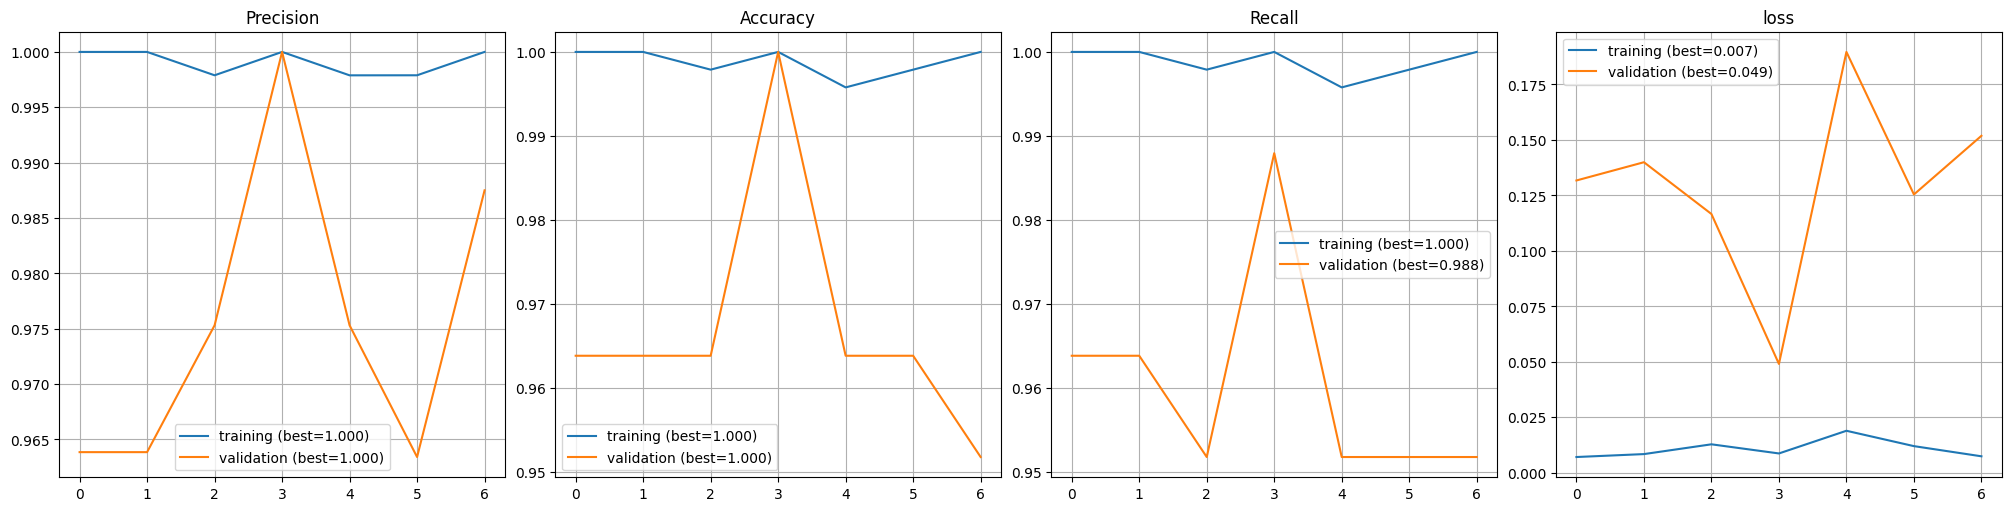

In [19]:
h_df = pd.DataFrame(history.history)

metrics = set([k.split('_')[-1] for k in history.history.keys()])

fig, axs = plt.subplots(ncols=len(metrics), nrows=1, constrained_layout=True, figsize=(20,5))

for plot_idx, metric in enumerate(metrics):
    best = h_df.max(0) if metric != 'loss' else h_df.min(0)
    axs[plot_idx].plot(
        history.history[metric],
        label=f'training (best={best[metric]:.3f})'
    )
    axs[plot_idx].plot(
        history.history['val_'+metric],
        label=f'validation (best={best["val_"+metric]:.3f})'
    )
    axs[plot_idx].grid(True)
    axs[plot_idx].set_title(metric)
    axs[plot_idx].legend()